# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

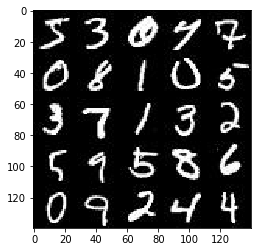

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

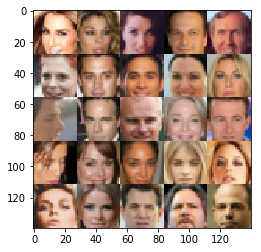

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/carmenl/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.in

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    # Input images is 28x28
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x64 filters, skip batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x128 filters
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 4x4x256 filters
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten image
        flat_image = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat_image, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # 7x7x512
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28x28x3
        logits = tf.tanh(tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same'))
        
        return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)

    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    images, dimensions, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(images, dimensions, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={images: batch_images, dimensions: batch_z})
                _ = sess.run(g_opt, feed_dict={images: batch_images, dimensions: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({images: batch_images, dimensions: batch_z})
                    train_loss_g = g_loss.eval({dimensions: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, dimensions, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3118... Generator Loss: 10.6019
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 1.7712
Epoch 1/2... Discriminator Loss: 0.2945... Generator Loss: 4.6106
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 5.2645
Epoch 1/2... Discriminator Loss: 1.8263... Generator Loss: 4.0070
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.6644
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 1.1413
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.6064... Generator Loss: 1.5709


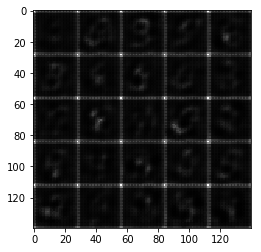

Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.5886
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.2038
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.6109


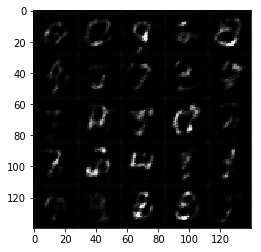

Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.1942
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.5861... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8932


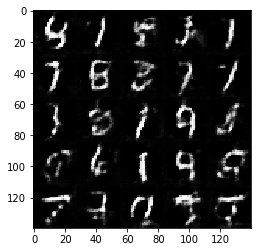

Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.7044
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.9292
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 1.6015... Generator Loss: 0.3334


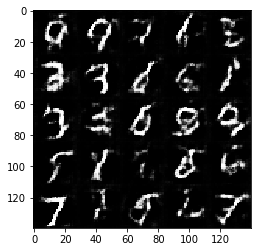

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 1.5128
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 0.9646
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 1.0587
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 0.8678


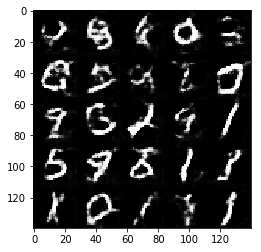

Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 1.2111
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.3672
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.6138


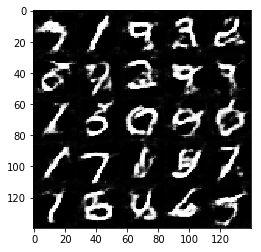

Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.3882
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 1.7404
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.6439... Generator Loss: 0.2884
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.5087


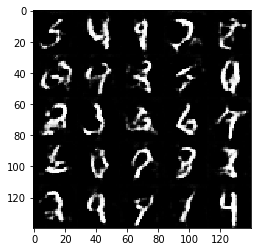

Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.8143
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.1560
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.6743


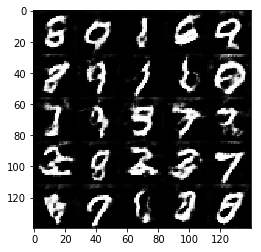

Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 1.6713
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 0.9792


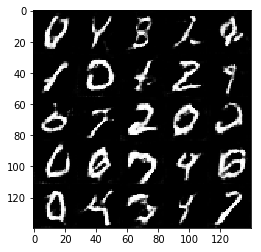

Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.8507
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.3688
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.2241
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.3916
Epoch 2/2... Discriminator Loss: 1.8932... Generator Loss: 0.2576
Epoch 2/2... Discriminator Loss: 1.7440... Generator Loss: 2.6627


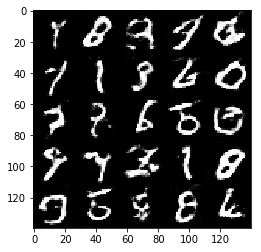

Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 1.1713
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.6633... Generator Loss: 0.3236
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.4323
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.4592


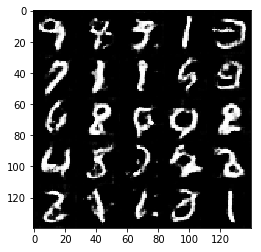

Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 1.2742


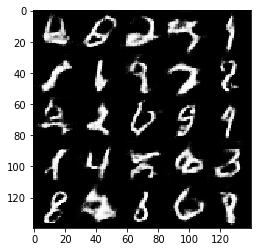

Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 1.6711... Generator Loss: 0.3137
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 1.7556... Generator Loss: 0.2992
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.6558
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.2184


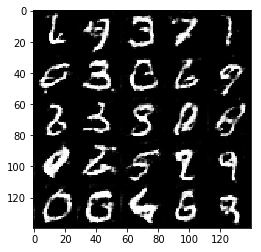

Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 3.0105... Generator Loss: 3.3775
Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.4611
Epoch 2/2... Discriminator Loss: 1.4927... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.2788


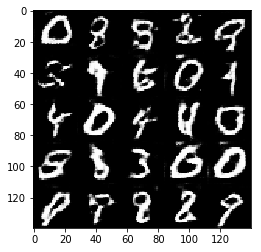

Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 2.0036
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.9141


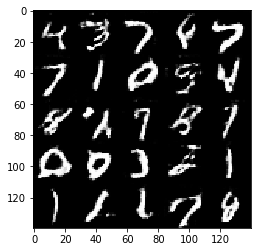

Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 2.5448
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 0.7281... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 1.5790
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.5007
Epoch 2/2... Discriminator Loss: 0.6730... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.4071
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 1.0723


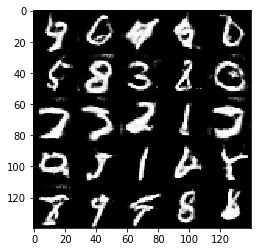

Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 1.6394... Generator Loss: 0.3795
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 2.1208
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 1.8364
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.5647


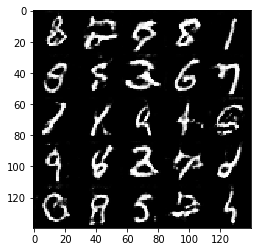

Epoch 2/2... Discriminator Loss: 1.7989... Generator Loss: 0.2897
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 2.1684
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 1.7384
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.0444
Epoch 2/2... Discriminator Loss: 0.4607... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.6536


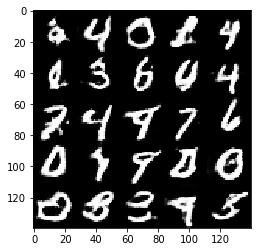

Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.2750
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.4747


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 4.4854
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 2.5191... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 2.1338... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.9789... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6272


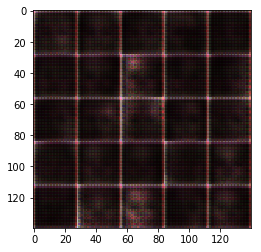

Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.7644... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.8306... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.4444


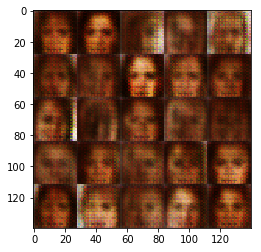

Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 2.0507... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.2841
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 2.5025... Generator Loss: 0.1892
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8559


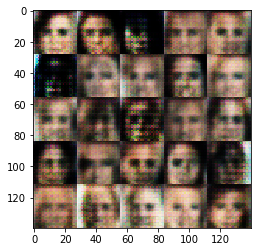

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8015


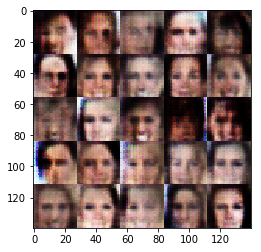

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.6490


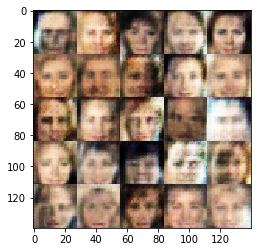

Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6811


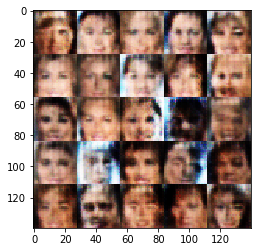

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.9252


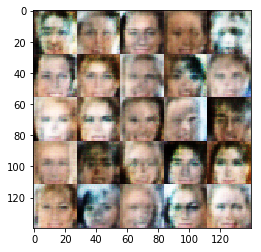

Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7770


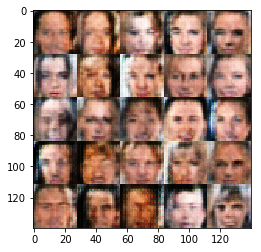

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7436


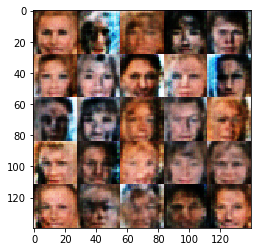

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7687


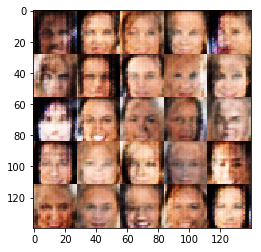

Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7652


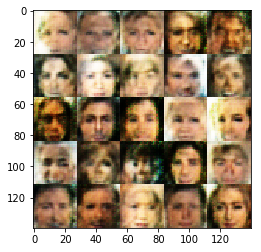

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6891


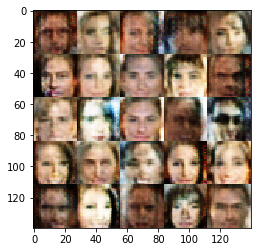

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6252


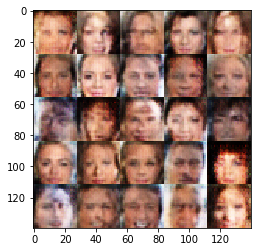

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6810


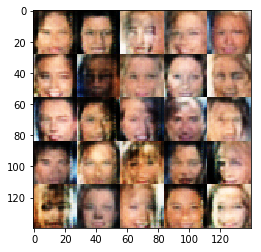

Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6286


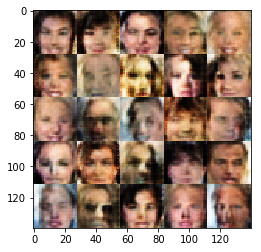

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8370


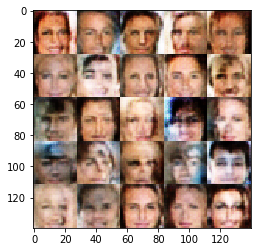

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5079


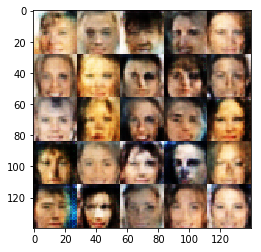

Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7622


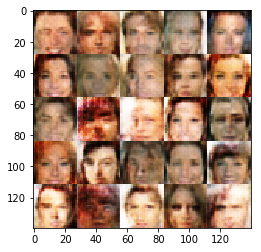

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7643


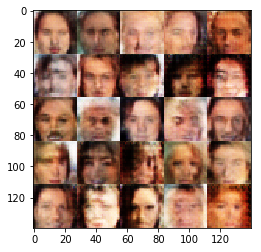

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7715


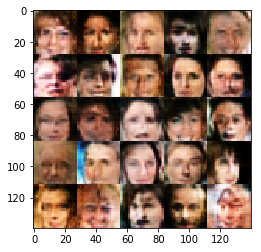

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7322


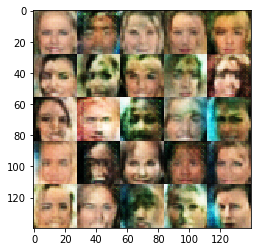

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8123


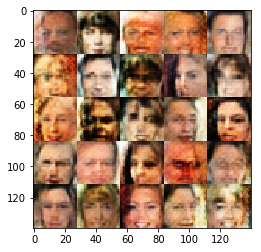

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0510


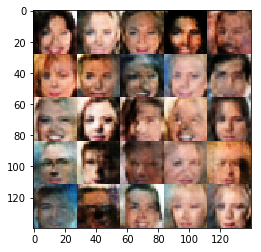

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5589


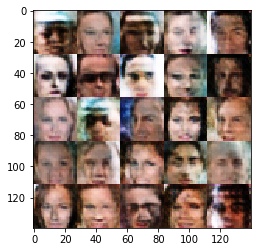

Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7254


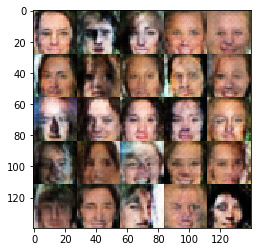

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.8067... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.3096


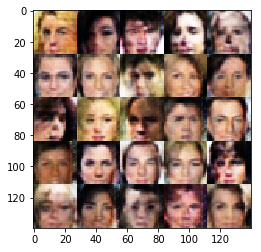

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5256


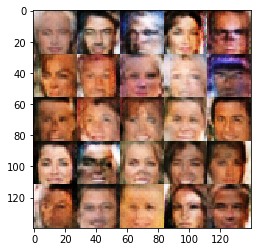

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8808


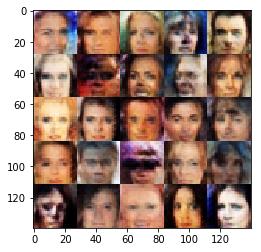

Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.6712


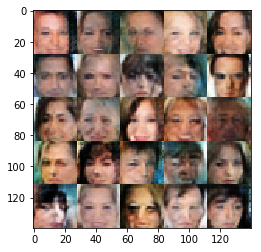

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.3977


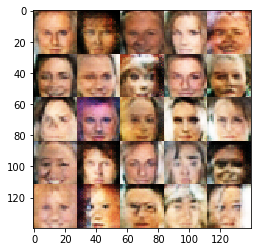

Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.5523


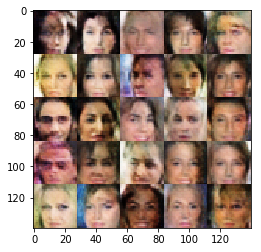

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.5717


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.